In [1]:
from sympy import *
init_printing()

import numpy as np
import matplotlib.pyplot as plt

## Goal
Design a TCP algorithm that is fast, but not necessarily instant. It seems that all instant-TCP designs tend to have an equilibrium wherethe queue is a linear function of the RTT. This works quite well in most cases, but leads to severe RTT unfairness---the sender with the largest RTT takes over all of the bandwidth. This equilibrium is inherently RTT unfair.

This motivates us to look for other equilibria which are not RTT-unfair. Presumably we cannot have instant-TCP with such equilibriua, but we'll try to move as fast as possible anyway.

### Notation

$d_q$: queuing delay

$w$: congestion window

$R_m$: minimum RTT (propagation delay)

$\mu$: link rate

$B = \mu R_m$: BDP

$R = w/\mu$: RTT

Note, $d_q = \left(\frac{w - B}{\mu}\right)^+$

<a id="stability-condition"></a>
### Stability Condition
If our dynamics leads to a condition where:

$$ \frac{\mathrm{d}w}{\mathrm{d}t} = m * (w - e_{eq}) $$

around the equilibrium point (i.e. when $\Delta w = w - w_{eq}$ is small), then the system is unstable unless:

$$ -\frac{\pi}{2R} < m < 0 $$

In [116]:
d_q, w, R_m, mu, B, R = symbols('d_q w R_m \\mu B R', positive=True, real=True)

# Some identities. Notation: (LHS, RHS) for the identity LHS=RHS
ident_B = (B, mu * R_m)
ident_R_m = (R_m, B / mu)
ident_mu = (mu, w / R)
# Note: The following identities are only valid if w >= B (i.e. link is fully utilized)
ident_R = (R, w / mu)
ident_d_q = (d_q, (w - B) / mu)

### Dynamics
To ensure stability, we'll probably need a more flexible dynamic than just 'set the current rate to the target rate'. Instead we'll need to move more slowly. Say we move as follows:

$$ w_{new} \leftarrow \beta \cdot w_{old} + (1 - \beta) \cdot \tau(d_q) $$

here, $0 \le \beta \le 1$ and $w_{old}$ is the cwnd from 1 RTT ago. Larger $\beta$ will move slower and $\beta=0$ corresponds to instant TCP. We expect that $\beta$ will be a function of $R$, and cause senders with larger RTTs to move slower. The hope is that we move the $R$-dependence away from $\tau$ and into $\beta$.

With this dynamic,

$$ \frac{\mathrm{d}w}{\mathrm{d}t} = \frac{w_{new} - w_{old}}{R} = \frac{1 - \beta}{R} \left(\tau(d_q) - w_{old}\right) $$

Now, linearizing around equilibrium, we have (note, $d_q$ is a function of $w_{old}$)

$$ \tau(d_q) \approx w_{eq} + \left. \frac{\mathrm{d}\tau(d_q)}{\mathrm{d}w} \right|_{w_{eq}} \cdot (w_{old} - w_{eq}) $$

$$ \Rightarrow \tau(d_q) - w_{old} \approx \left( \left. \frac{\mathrm{d}\tau(d_q)}{\mathrm{d}w} \right|_{w_{eq}} - 1 \right) \cdot (w_{old} - w_{eq}) $$

Substuting in $\frac{\mathrm{d}w}{\mathrm{d}t}$ and comparing with equations in section [stability condition](#stability-condition), we want

$$ -\frac{\pi}{2R} < \frac{1 - \beta}{R} \left(\left. \frac{\mathrm{d}\tau(d_q)}{\mathrm{d}w} \right|_{w_{eq}} - 1 \right) < 0 $$

**Note:** Think carefully about whether we can use $w_{old}$ in place of $w$ in the stability condition

### Desired Equilibrium

Let $\tau(d_q)$ be the target cwnd. Let us start by exploring the equilibrium where:
    
$$ \tau(d_q) = \frac{\alpha R}{d_q^2} $$

The 'square' in the denominator helps reduce the precision needed to measure the queuing delay. The $R$ is there since this is cwnd, and we want to set rate to be idependent of $R$

We now compute the equilibrium point for this function

In [132]:
alpha = symbols('alpha', positive=True, real=True)
beta = symbols('beta', real=True)
tau = alpha * R / d_q ** 2
tau 

In [133]:
# Determine the equilibrium condition
eqn = (w - tau).subs(*ident_d_q).subs(*ident_R)
w_eq_solns = solve(eqn, w)
w_eq_solns

In [134]:
# Note: We can ignore solutions where w_eq < B since ident_R and ident_d_q don't apply when w < B
w_eq = w_eq_solns[1]
w_eq

### Sensitivity Analysis
One challenge is that we need to measure queuing delay quite precisely. Let us study how mcuh an error in estimating $d_q$ affects the sending rate ($w/R$)

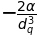

In [143]:
dtau_ddq = simplify(diff(tau/R, d_q))
dtau_ddq

In [144]:
# Find the value at equilibrium
dtau_ddq.subs(d_q, (w_eq - B) / mu)

In Copa, $\frac{\mathrm{d} \tau}{\mathrm{d} d_q} = -\frac{\mu^2}{\alpha}$ at equilibrium, which is higher than here. Hence it is more sensitive. Decreasing sensitivity will help improve robustness to measurement error. Additionally, one problem was that if the equilibrium queuing delay is less than the least-count of our measurement, Copa severely under-utilizes the link. Maintaining more packets at equilibirum reduces the severity of this problem

### Stability analysis
Apply the stability condition to our equilibrium

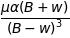

In [145]:
# Differentiate tau w.r.t w
dtau_dw = diff(tau.subs(*ident_d_q).subs(*ident_R), w)
simplify(dtau_dw)

In [146]:
# Substitute w_eq and simplify
dtau_dw__eq = simplify(dtau_dw.subs(w, w_eq))
dtau_dw__eq

In [147]:
# In the stability condition, the following quantity must be < 0 and > -pi/2
stab = (1 - beta) * (dtau_dw__eq - 1)
stab

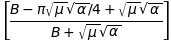

In [148]:
# Solve beta for stability
beta_solns = solve(stab + pi/2, beta)
beta_soln = beta_solns[0]
beta_solns

Simplifying this manually, we get

$$ \beta = 1 - \frac{\pi}{4}\frac{\sqrt{\mu\alpha}}{B + \sqrt{\mu\alpha}} $$

At equilibrium, $\beta = 1 - \frac{\pi}{4}\frac{d_q}{R}$. However, we shouldn't use this to determine $\beta$, since $d_q = 0$ (and $\beta = 1$) when the link isn't fully utilized, and the algorithm will never get to the equilibrium.

Instead, we substitute $B = \mu R_m$ and use the current estimate of $\mu$ to determine $\beta$. Then we get:

$$\beta = 1 - \frac{\pi}{4}\frac{\sqrt{\alpha}}{\sqrt{\mu}R_m + \sqrt{\alpha}} $$

This starts out moving quickly toward equilibirum and then slows down as it gets closer. It is slower (and hence more careful) for larger $R_m$. This behavior is intuitively satisfying.